# Import All Neccessary Library

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import validation_curve
from sklearn.calibration import label_binarize
from sklearn.metrics import auc, roc_curve
from scipy.stats import chi2_contingency
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output


# Import Dataset

In [136]:
dataset_BurnoutLevel = "C:/Users/Jia Xuan/Downloads/fyp-linked-github/fyp_Degree/synthetic-employee-dataset.json"

df2 = pd.read_json(dataset_BurnoutLevel)

In [137]:
useless_cols = ['employee_id','department', 'role','job_level','tenure_months','salary',
                'team_sentiment','recent_feedback', 'performance_score',
                'communication_patterns', 'training_participation','collaboration_score',
                'technical_skills', 'soft_skills', 'email_sentiment','slack_activity','meeting_participation',
                'turnover_reason', 'risk_factors_summary','turnover_probability_generated','overtime_hours',
                'risk_factors_summary', 'persona_name','role_complexity_score','career_progression_score','left_company']

df2 = df2.drop(columns=useless_cols)

In [138]:
df2['satisfaction_score'] = df2['satisfaction_score']*10
df2['project_completion_rate'] = df2['project_completion_rate']*10
df2['goal_achievement_rate'] = df2['goal_achievement_rate']*10
df2['stress_level'] = df2['stress_level']*10
df2['burnout_risk'] = df2['burnout_risk']*10
df2['workload_score'] = df2['workload_score']*10

# Data Understanding

In [139]:
numerical_cols = df2.select_dtypes(include=np.number).columns
categorical_cols = df2.select_dtypes(include=["object", "bool"]).columns

## Dataset Overview

In [140]:
df2.head()

,satisfaction_score,workload_score,project_completion_rate,goal_achievement_rate,stress_level,burnout_risk
0,6.237460,7.581168,5.241873,6.324821,9.089919,8.666426
1,9.825562,7.884164,5.582056,5.385873,3.633211,2.189959
2,7.672001,6.976166,5.668491,6.246560,6.643785,5.415310
3,1.858883,4.931429,7.674564,9.593204,10.000000,10.000000
4,5.667061,5.672299,5.972346,6.773053,7.230486,6.148245


## Dataset Structure Description

In [141]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849999 entries, 0 to 849998
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   satisfaction_score       849999 non-null  float64
 1   workload_score           849999 non-null  float64
 2   project_completion_rate  849999 non-null  float64
 3   goal_achievement_rate    849999 non-null  float64
 4   stress_level             849999 non-null  float64
 5   burnout_risk             849999 non-null  float64
dtypes: float64(6)
memory usage: 38.9 MB


## Summary Statistics

In [142]:
df2.describe()

,satisfaction_score,workload_score,project_completion_rate,goal_achievement_rate,stress_level,burnout_risk
count,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000
mean,5.819411,5.994901,5.954121,6.920272,7.910480,7.359405
std,2.762678,2.000377,1.611726,1.839112,2.645358,3.157564
min,0.500000,0.067413,0.592903,0.741128,0.000000,0.000000
25%,3.670161,4.556570,4.901786,5.713397,6.130047,4.799497
50%,5.831881,6.137435,6.094987,6.992348,9.421513,9.144943
75%,8.139123,7.566928,7.161492,8.255846,10.000000,10.000000
max,10.000000,9.996147,10.000000,10.000000,10.000000,10.000000


## Distribution Analysis for Numerical Features

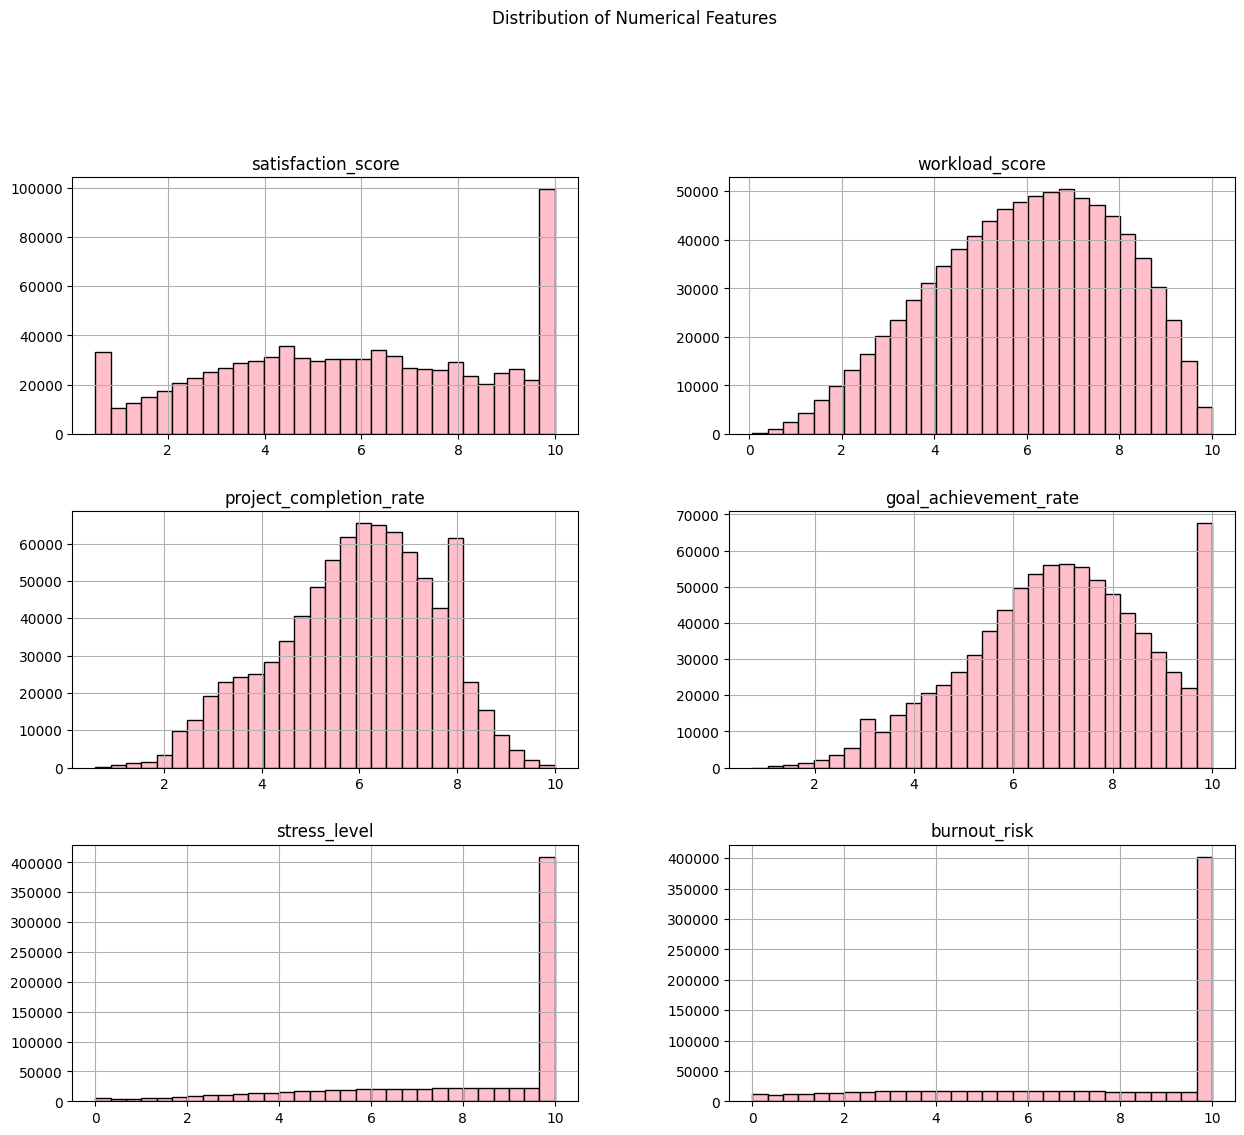

In [143]:
df2[numerical_cols].hist(
    figsize=(15, 12),
    bins=30,
    color='pink',
    edgecolor='black'
)

plt.suptitle("Distribution of Numerical Features", y=1.02)
plt.show()


## Corelation Analysis

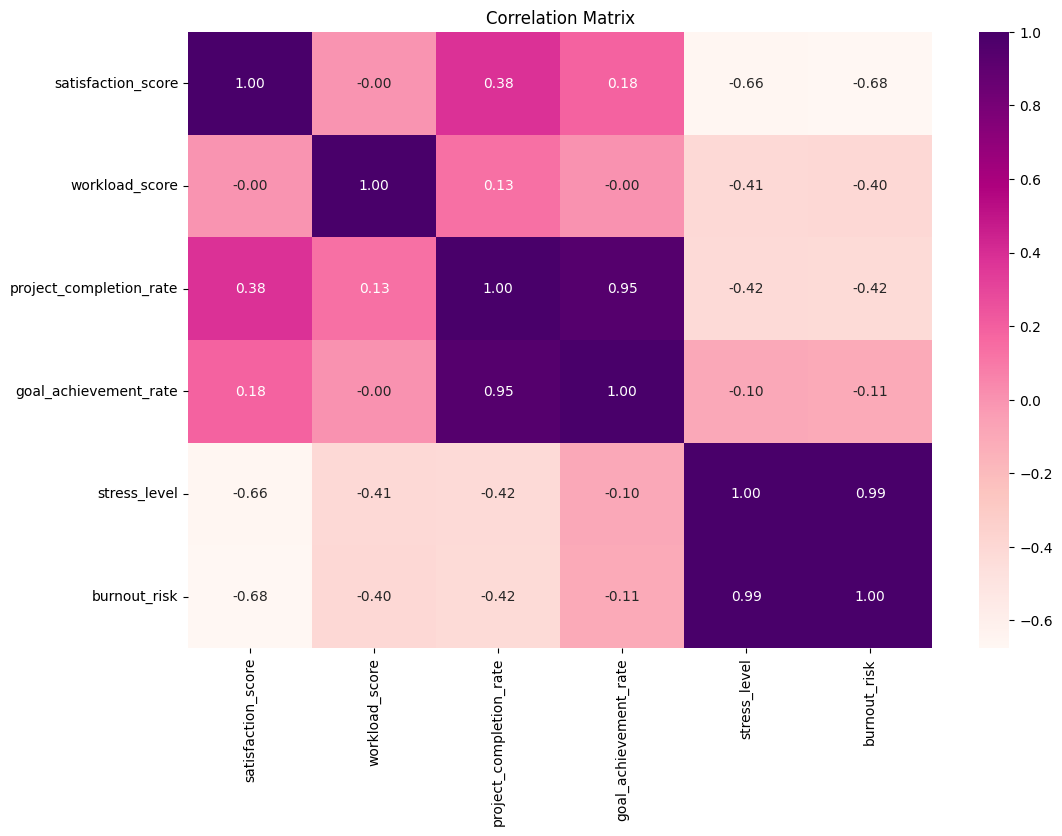

In [144]:
corr = df2[numerical_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdPu")
plt.title("Correlation Matrix")
plt.show()

## Data Quality Analysis

### Missing Value Analysis

In [145]:
df2.isnull().sum()

satisfaction_score         0
workload_score             0
project_completion_rate    0
goal_achievement_rate      0
stress_level               0
burnout_risk               0
dtype: int64

### Outlier Analysis

In [146]:
numerical_cols = df2.select_dtypes(include=np.number).columns

outlier_count = []

for col in numerical_cols:
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    count = ((df2[col] < lower) | (df2[col] > upper)).sum()
    
    outlier_count.append({
        "Column": col,
        "Number_of_Outliers": count
    })

iqr_outlier_df2 = pd.DataFrame(outlier_count)

iqr_outlier_df2.sort_values("Number_of_Outliers", ascending=False)


,Column,Number_of_Outliers
4,stress_level,4939
3,goal_achievement_rate,2048
2,project_completion_rate,1756
0,satisfaction_score,0
1,workload_score,0
5,burnout_risk,0


### Duplicate Data Analysis

In [147]:
duplicate_rows = df2.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicate_rows}")

Number of Duplicate Rows: 0


# Data Preprocessing

## Drop duplicate rows

In [105]:
# Keep first occurrence (default)
df2 = df2.drop_duplicates(keep='first')

duplicate_rows = df2.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicate_rows}")

Number of Duplicate Rows: 0


## Outlier Handling

In [148]:
# --- Outliers BEFORE cleaning ---
Q1 = df2[numerical_cols].quantile(0.25)
Q3 = df2[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers_before = ((df2[numerical_cols] < lower) | (df2[numerical_cols] > upper)).sum()

# --- Clip the outliers (IQR method) ---
for col in numerical_cols:
    df2[col] = np.clip(df2[col], lower[col], upper[col])

# --- Outliers AFTER cleaning ---
outliers_after = ((df2[numerical_cols] < lower) | (df2[numerical_cols] > upper)).sum()

# --- Comparison table ---
outlier_comparison = pd.DataFrame({
    'Before': outliers_before,
    'After': outliers_after
})

outlier_comparison


,Before,After
satisfaction_score,0,0
workload_score,0,0
project_completion_rate,1756,0
goal_achievement_rate,2048,0
stress_level,4939,0
burnout_risk,0,0


In [149]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849999 entries, 0 to 849998
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   satisfaction_score       849999 non-null  float64
 1   workload_score           849999 non-null  float64
 2   project_completion_rate  849999 non-null  float64
 3   goal_achievement_rate    849999 non-null  float64
 4   stress_level             849999 non-null  float64
 5   burnout_risk             849999 non-null  float64
dtypes: float64(6)
memory usage: 38.9 MB


# Target Analysis

In [150]:
def create_risk_category(score):
    if score < 4: return 'Low'
    elif score < 7: return 'Medium'
    else: return 'High'

df2['risk_label'] = df2['burnout_risk'].apply(create_risk_category)



print("Burnout Risk Distribution:")
print(df2['risk_label'].value_counts())
print(f"\nPercentage Distribution:")
print(df2['risk_label'].value_counts(normalize=True) * 100)

Burnout Risk Distribution:
risk_label
High      525642
Low       171105
Medium    153252
Name: count, dtype: int64

Percentage Distribution:
risk_label
High      61.840308
Low       20.130024
Medium    18.029668
Name: proportion, dtype: float64


In [151]:
X = df2.drop(columns=['risk_label', 'burnout_risk','stress_level'])
y = df2['risk_label']

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)

X_balanced, y_balanced = rus.fit_resample(X, y)

print(f"Balanced Dataset Distribution: {Counter(y_balanced)}")

Balanced Dataset Distribution: Counter({'High': 153252, 'Low': 153252, 'Medium': 153252})


In [152]:
df_reduced = df2.sample(frac=0.5, random_state=42)

print(f"Original shape: {df2.shape}")
print(f"Reduced shape: {df_reduced.shape}")

Original shape: (849999, 7)
Reduced shape: (425000, 7)


# Models to predict BurnOut Risk Level

## Label Encoding

In [153]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_balanced)

## Train Test Split

In [154]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

## Baseline Classification Models

In [155]:
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, objective='multi:softprob',
                             num_class=3, random_state=42) }

for name, model in base_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Logistic Regression Accuracy: 0.9956
Decision Tree Accuracy: 0.8157
Random Forest Accuracy: 0.8695
XGBoost Accuracy: 0.9706


## Hyperparameter Tuning Model

In [ ]:
param_grids = {
    "Logistic Regression": {
        "C": [0.1, 1, 10],
        "solver": ['saga'] # Faster for large datasets
    },
    "Decision Tree": {
        "max_depth": [10, 20, 30, None],
        "min_samples_split": [2, 10, 20]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20],
        "min_samples_leaf": [1, 4]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6, 9],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0]
    }
}

X_train, y_train = shuffle(X_train, y_train, random_state=42)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_estimators = {}

# Loop through models and tune
for name, grid in param_grids.items():
    print(f"Tuning {name}...")
    
    # Initialize base model
    if name == "Logistic Regression":
        model = LogisticRegression(max_iter=1000, multi_class='multinomial')
    elif name == "Decision Tree":
        model = DecisionTreeClassifier()
    elif name == "Random Forest":
        model = RandomForestClassifier(n_jobs=-1)
    else: # XGBoost
        model = XGBClassifier(objective='multi:softprob', num_class=3)

    # Run Randomized Search
    rs = RandomizedSearchCV(
        model, 
        param_distributions=grid, 
        n_iter=5, # Number of random combinations to try
        cv=skf, 
        scoring='accuracy', 
        random_state=42, 
        n_jobs=-1
    )
    
    rs.fit(X_train, y_train)
    best_estimators[name] = rs.best_estimator_
    print(f"Best params for {name}: {rs.best_params_}\n")

Tuning Logistic Regression...


c:\Users\Jia Xuan\miniconda3\envs\FYP\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Jia Xuan\miniconda3\envs\FYP\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Jia Xuan\miniconda3\envs\FYP\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best params for Logistic Regression: {'solver': 'saga', 'C': 10}

Tuning Decision Tree...
Best params for Decision Tree: {'min_samples_split': 2, 'max_depth': None}

Tuning Random Forest...
Best params for Random Forest: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_depth': 20}

Tuning XGBoost...
Best params for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.2}



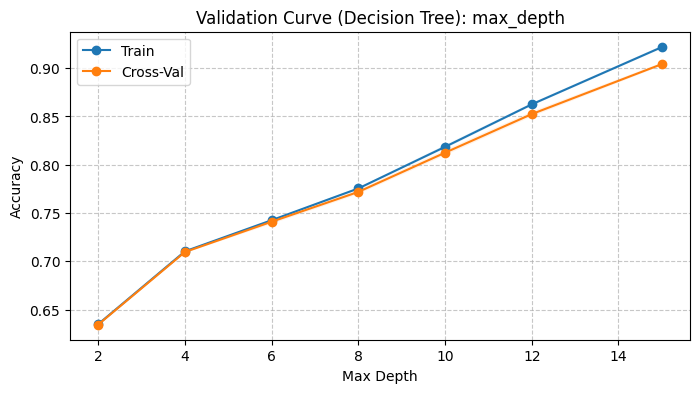

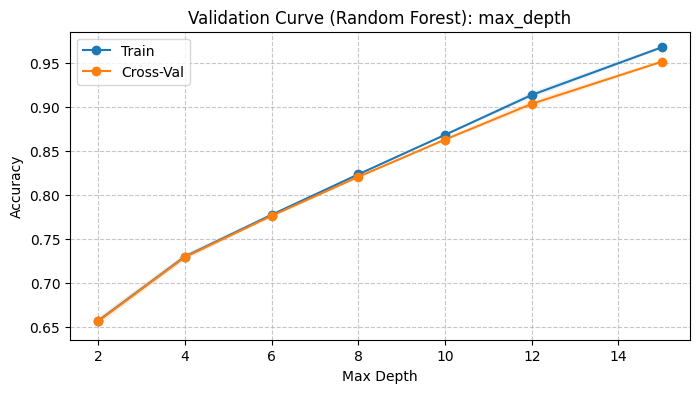

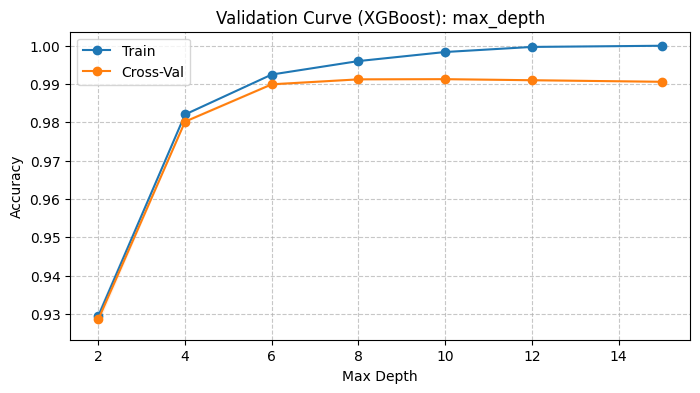

In [157]:
models_to_compare = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}
param_range = [2, 4, 6, 8, 10, 12, 15]

for name, model in models_to_compare.items():
    train_v, test_v = validation_curve(
        model, X_balanced, y_encoded, 
        param_name="max_depth", 
        param_range=param_range, 
        cv=5, # Increased CV for more stable estimates
        scoring="accuracy", 
        n_jobs=-1
    )
    
    # Calculate means and standard deviations for the "fill" area
    train_mean = np.mean(train_v, axis=1)
    train_std = np.std(train_v, axis=1)
    test_mean = np.mean(test_v, axis=1)
    test_std = np.std(test_v, axis=1)

    plt.figure(figsize=(8, 4))
    
    # Plotting with transparency (std dev) helps show if the results are "lucky" or stable
    plt.plot(param_range, train_mean, label="Train", marker='o')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
    
    plt.plot(param_range, test_mean, label="Cross-Val", marker='o')
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1)
    
    plt.title(f"Validation Curve ({name}): max_depth")
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

## Ensemble Model

In [158]:
from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(
    estimators=[
        ('lr', best_estimators["Logistic Regression"]),
        ('dt', best_estimators["Decision Tree"]),
        ('rf', best_estimators["Random Forest"]),
        ('xgb', best_estimators["XGBoost"])
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print("===== Stacking Ensemble Performance =====")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")


===== Stacking Ensemble Performance =====
Accuracy: 0.9992
Precision: 0.9992, Recall: 0.9992, F1-Score: 0.9992


## Final Evaluation

In [161]:
# Add stacking model to the dictionary of models to evaluate
all_models = best_estimators.copy()
all_models["Stacking Ensemble"] = stacking_model

# 1. Update Metrics Table
comparison_list = []
for name, model in all_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    comparison_list.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-Score": round(f1, 4)
    })

df_results = pd.DataFrame(comparison_list).sort_values(by="Accuracy", ascending=False)
display(df_results)


,Model,Accuracy,Precision,Recall,F1-Score
4,Stacking Ensemble,0.9992,0.9992,0.9992,0.9992
0,Logistic Regression,0.9974,0.9974,0.9974,0.9974
3,XGBoost,0.9917,0.9917,0.9917,0.9917
2,Random Forest,0.9767,0.9772,0.9767,0.9768
1,Decision Tree,0.9670,0.9670,0.9670,0.9670


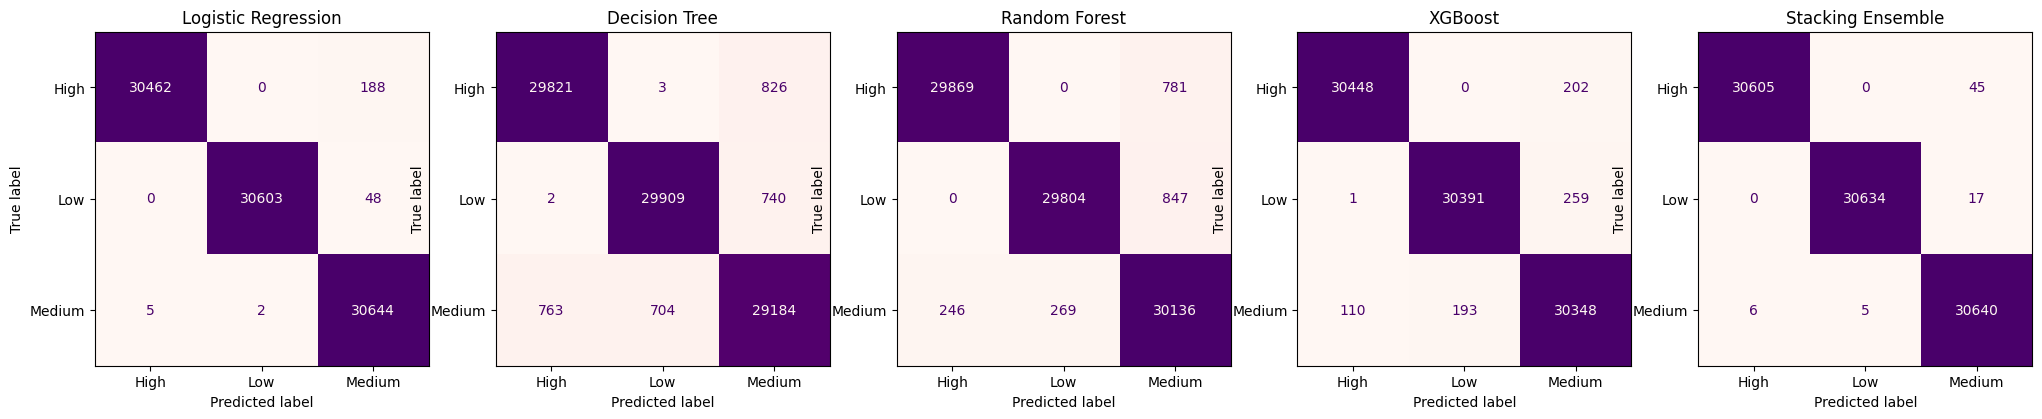

In [162]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5)) # Adjusted for 5 models
for i, (name, model) in enumerate(all_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='RdPu', values_format='d', ax=axes[i], colorbar=False)
    axes[i].set_title(name)
plt.show()

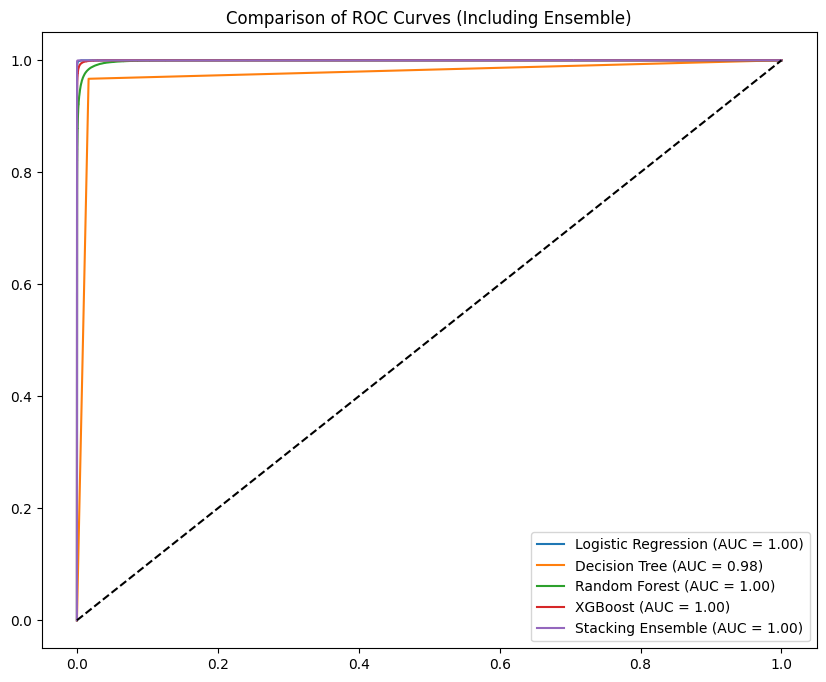

In [163]:
plt.figure(figsize=(10, 8))
for name, model in all_models.items():
    y_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=[0,1,2]).ravel(), y_prob.ravel())
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Comparison of ROC Curves (Including Ensemble)")
plt.legend()
plt.show()

In [120]:
# Use the names exactly as they appeared in your list
feature_col = 'stress_level_binned'
target_col = 'risk_label'

# Ensure the binned column is created in df2
df2['stress_level_binned'] = pd.cut(df2['stress_level'], 
                                   bins=3, 
                                   labels=['Low Stress', 'Medium Stress', 'High Stress'])

# Run the test
contingency_table = pd.crosstab(df2[feature_col], df2[target_col])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"--- Chi-Square Test: {feature_col} vs {target_col} ---")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p:.4e}")

if p < 0.05:
    print(f"Result: Significant relationship found between Stress Levels and Risk Labels.")
else:
    print(f"Result: No significant relationship found.")

--- Chi-Square Test: stress_level_binned vs risk_label ---
Chi-Square Statistic: 791186.0350
P-value: 0.0000e+00
Result: Significant relationship found between Stress Levels and Risk Labels.


In [125]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    stacking_model, X_balanced, y_encoded,
    cv=5, scoring='accuracy', n_jobs=-1
)
print("CV Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))


CV Accuracy: 0.9989 ± 0.0001


## Feature Importances

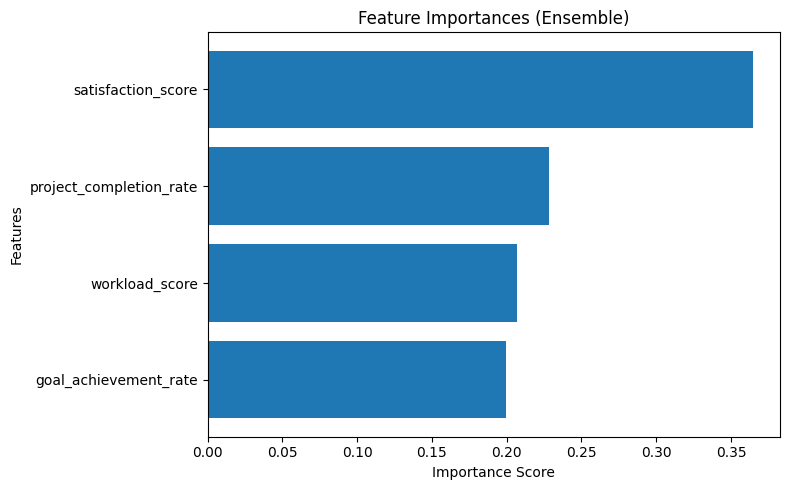

In [164]:
importances = best_estimators["XGBoost"].feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=True).tail(10)

plt.figure(figsize=(8, 5))
plt.barh(feat_imp.index, feat_imp.values)
plt.title("Feature Importances (Ensemble)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [ ]:
# Save the Stacking Ensemble as the final production model
joblib.dump(stacking_model, 'burnout_stacking_model.pkl')

# Save the LabelEncoder (crucial for decoding predictions later)
joblib.dump(le, 'burnout_label_encoder.pkl')

['burnout_label_encoder.pkl']

# Test Deployment

In [ ]:
# 1. Load the specific classification assets
# Ensure these files are in your current working directory
model = joblib.load('burnout_stacking_model.pkl')
label_encoder = joblib.load('burnout_label_encoder.pkl')

# 2. Setup the Input Interface
style = {'description_width': 'initial'}

inputs = {
    'satisfaction_score': widgets.FloatSlider(
        value=5.0, min=0.0, max=10.0, step=0.1, 
        description='Satisfaction (0-10):', style=style),
    
    'project_completion_rate': widgets.FloatSlider(
        value=5.0, min=0.0, max=10.0, step=0.1, 
        description='Project Completion (0-10):', style=style),
    
    'goal_achievement_rate': widgets.FloatSlider(
        value=5.0, min=0.0, max=10.0, step=0.1, 
        description='Goal Achievement (0-10):', style=style),

    'workload_score': widgets.FloatSlider(
        value=5.0, min=0.0, max=10.0, step=0.1, 
        description='Workload Score (0-10):', style=style),
}

btn = widgets.Button(
    description="Predict Burnout Risk", 
    button_style='warning', # Orange color
    layout={'width': '300px'}
)
output = widgets.Output()

# 3. Prediction Logic
def predict_burnout(b):
    with output:
        clear_output()
        
        data_dict = {
            'satisfaction_score': inputs['satisfaction_score'].value,
            'project_completion_rate': inputs['project_completion_rate'].value,
            'goal_achievement_rate': inputs['goal_achievement_rate'].value,
            'workload_score': inputs['workload_score'].value,
        }
        
        # 2. Convert to DataFrame
        user_data = pd.DataFrame([data_dict])
        
        # 3. FORCE THE ORDER (This is the fix)
        # Replace this list with the EXACT order of your X_train columns
        correct_order = ['satisfaction_score', 'workload_score', 'project_completion_rate', 'goal_achievement_rate']
        user_data = user_data[correct_order]
        
        # Get the numerical prediction
        prediction_idx = model.predict(user_data)[0]
        
        # Get probabilities for all classes
        probs = model.predict_proba(user_data)[0]
        
        # Decode the numerical class back to 'Low', 'Medium', or 'High'
        risk_label = label_encoder.inverse_transform([prediction_idx])[0]
        
        # Display Results
        print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
        print(f"🔥 PREDICTED RISK LEVEL: {risk_label.upper()}")
        print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
        
        # Show Confidence
        for i, class_name in enumerate(label_encoder.classes_):
            print(f"{class_name} Risk Probability: {probs[i]*100:.2f}%")
            
        # Contextual recommendation
        if risk_label == 'High':
            print("\n⚠️ Recommendation: High risk! Immediate workload reduction required.")
        elif risk_label == 'Medium':
            print("\n🔔 Recommendation: Moderate risk. Monitor stress levels closely.")
        else:
            print("\n✅ Recommendation: Balanced. Current habits are sustainable.")

btn.on_click(predict_burnout)

# 4. Render UI
display(widgets.HTML("<h2>🔥 Burnout Risk Level Classifier</h2>"))
for widget in inputs.values():
    display(widget)
display(btn, output)

HTML(value='<h2>🔥 Burnout Risk Level Classifier</h2>')

FloatSlider(value=5.0, description='Satisfaction (0-10):', max=10.0, style=SliderStyle(description_width='init…

FloatSlider(value=5.0, description='Project Completion (0-10):', max=10.0, style=SliderStyle(description_width…

FloatSlider(value=5.0, description='Goal Achievement (0-10):', max=10.0, style=SliderStyle(description_width='…

FloatSlider(value=5.0, description='Workload Score (0-10):', max=10.0, style=SliderStyle(description_width='in…

Button(button_style='warning', description='Predict Burnout Risk', layout=Layout(width='300px'), style=ButtonS…

Output()